In [59]:
%matplotlib notebook
import pandas as pd
import numpy as np
import math
import statistics
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn import svm
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler, LabelEncoder, normalize
import matplotlib.pyplot as plt
import seaborn as sn
import matplotlib
from mlxtend.plotting import plot_confusion_matrix
import warnings
from scipy.signal import savgol_filter, find_peaks, correlate
from sklearn.decomposition import PCA
import scipy.fftpack as FFT
from sklearn.utils import shuffle
import joblib
warnings.filterwarnings('ignore')
matplotlib.rcParams['figure.figsize'] = [12,5]

## help functions

In [60]:
def sampling_freq(df):
    start = df['time'].iloc[0]
    sum_samples = 0
    index = 0
    while  (start + pd.to_timedelta(1, unit='s')) < df['time'].iloc[-1]:
        end =  start + pd.to_timedelta(1, unit='s')
        sum_samples += df[(df['time'] >= start) & (df['time'] < end)].shape[0]
        start += pd.to_timedelta(1, unit='s')
        index += 1
    return sum_samples/index

def convert_to_float(x):
    try:
        return np.float(x)
    except:
        return np.nan

def convert_to_datetime(x):
    dt = datetime.fromtimestamp(x // 1000000000)
    s = dt.strftime('%Y-%m-%d %H:%M:%S')
    s += '.' + str(int(x % 1000000000)).zfill(9)
    return s

def heatmap(cm, labels):
    df_cm = pd.DataFrame(cm, index=labels, columns=labels)
    plt.figure(figsize = (10,7))
    sn.heatmap(df_cm, annot=True)

    plt.show()
    
def preprocess(data, activity, type_, p, drop_interval_begin = 3, drop_interval_end = 3):
    #convert nanoseconds to date 
    data['time'] = data['time'].apply(convert_to_datetime) 
    data['time'] = pd.to_datetime(data['time'])

#convert to same data type
    for i in range(1, 4): 
        data[column_names_org[i]] = data[column_names_org[i]].apply(convert_to_float)
    
#drop rows with NaN values 
    data.dropna(axis=0, how='any', inplace=True) #TODO: invullen met mean, mod of median / interpolatie

#drop duplicates 
    data.drop_duplicates(subset=None, keep='first', inplace = True)
    
    #drop first and last 3 sec
    indexFirst = data[ (data['time'].iloc[0]+ pd.to_timedelta(drop_interval_begin, unit='s')) > data['time'] ].index
    data.drop(indexFirst , inplace=True)
    indexLast = data[ (data['time'].iloc[-1]- pd.to_timedelta(drop_interval_end, unit='s')) < data['time'] ].index
    data.drop(indexLast , inplace=True)
    
    #add activity label
    data['activity'] = activity
    data['type'] = type_
    data['proefpersoon'] = p
    
    return data

#feature extraction
def get_mean_window(df):
    return df.mean()

def get_min_window(df):
    return df.min()

def get_max_window(df):
    return df.max()

def get_std_window(df):
    return df.std()

def get_med_window(df):
    return df.median()

#TODO: scipy integrate
#TODO: voor elke as apart??
#measure of activity level (m/s²)
def get_signal_magnitude_area(df):
        sum = 0
        for i in range(0, len(df)):
            sum += (abs(df['x'].iloc[i]) + abs(df['y'].iloc[i]) + abs(df['z'].iloc[i]))
        return sum /len(df)
    #result = integrate.quad(lambda t: df['x'].apply(lambda n : abs(n)) + df['y'].apply(lambda n : abs(n)) + df['z'].apply(lambda n : abs(n)), 0, len(df))

#TODO: voor elke as apart??
#degree of movement intensity (m/s²)
def get_signal_magnitude_vector(df):
    sum = 0
    for i in range(0, len(df)):
        sum += math.sqrt(df['x'].iloc[i] * df['x'].iloc[i] + df['y'].iloc[i] * df['y'].iloc[i] + df['z'].iloc[i] * df['z'].iloc[i])
    return sum

#average angle (radian) between accelerometer vector and x as (parallel with arm)
def get_tilt_angle(df):
    df_cos = pd.DataFrame(columns=["tilt_ang"])
    df_dot = df['x']
    for i in range(0, len(df)):
        s = pd.Series({"tilt_ang" : (df_dot.iloc[i])/(math.sqrt(df['x'].iloc[i]*df['x'].iloc[i] + df['y'].iloc[i]*df['y'].iloc[i] + df['z'].iloc[i]*df['z'].iloc[i]))})
        df_cos=df_cos.append(s, ignore_index=True)
    df_angle = np.arccos(df_cos)
    return df_angle.mean()['tilt_ang']

def get_power_spectral_density(df):
    df_psd = np.abs(df)**2
    return df_psd.sum()

#TODO: datatype is object en niet compex nr
def get_entropy(df):
    entropy = []
    pdf = df / df.sum()
    for i in range (1, len(pdf.columns)):
        entropy.append(np.complex(-np.nansum(pdf.iloc[:,i] * np.log2(pdf.iloc[:,i]))))
    return entropy

#generate windows with 50% overlap
def windows(df, time, overlap):
    start = df.iloc[0]
    while  (start + pd.to_timedelta(time, unit='s')) < df.iloc[-1]:
        yield start, (start + pd.to_timedelta(time, unit='s'))
        if overlap:
            start += pd.to_timedelta(time/2, unit='s')
        else:
            start += pd.to_timedelta(time, unit='s')
    #last samples 
    yield (df.iloc[-1] - pd.to_timedelta(time, unit='s')), df.iloc[-1]
        
def feature_extraction_segmentation(data, window, overlap):
    column_names = ["x_mean", "y_mean", "z_mean", "x_min", "y_min", "z_min", "x_max", "y_max", "z_max",
                "x_std", "y_std", "z_std", "x_med", "y_med", "z_med", "activity"]
    df = pd.DataFrame(columns = column_names)

    for (start, end) in windows(data['time'], window, overlap):
        vw1 = data['time'] >= start
        vw2 = data['time'] < end
        mean = get_mean_window(data[vw1 & vw2])
        min = get_min_window(data[vw1 & vw2])
        max = get_max_window(data[vw1 & vw2])
        std = get_std_window(data[vw1 & vw2])
        med = get_med_window(data[vw1 & vw2])
        sma = get_signal_magnitude_area(data[vw1 & vw2])
        smv = get_signal_magnitude_vector(data[vw1 & vw2])
        tilt = get_tilt_angle(data[vw1 & vw2])
        #fourrier transform
        t_x = data[vw1 & vw2][['time','x']].set_index('time')
        t_y = data[vw1 & vw2][['time','y']].set_index('time')
        t_z = data[vw1 & vw2][['time', 'z']].set_index('time')

        df_f = pd.DataFrame(columns=['f', 'x_f', 'y_f', 'z_f'])

    #TODO: determine sampling rate (datapoints per second)
        sampling_rate = 52

        df_f['x_f'] = FFT.fft(t_x).ravel()
        df_f['y_f'] = FFT.fft(t_y).ravel()
        df_f['z_f'] = FFT.fft(t_z).ravel()
        df_f['f'] = FFT.fftfreq(len(df_f['x_f'])) * sampling_rate

        psd = get_power_spectral_density(df_f)
        #entropy = get_entropy(df_f)

        df = df.append(pd.Series({'x_mean': mean['x'], 'y_mean': mean['y'], 'z_mean': mean['z'], "x_min" : min['x'],
                              "y_min" : min['y'], "z_min" : min['z'], "x_max" : max['x'], "y_max" : max['y'], "z_max" : max['z'],
                              "x_std" : std['x'], "y_std" : std['y'], "z_std" : std['z'], "x_med" : med['x'], "y_med" : med['y'], "z_med" : med['z'],
                              "sma" : sma, "smv" : smv, "tilt" : tilt, "x_psd" : psd['x_f'], "y_psd" : psd['y_f'], "z_psd" : psd['z_f']
                              , "activity" : data['activity'].iloc[0]}), ignore_index=True) # "x_entropy" : entropy[0], "y_entropy" : entropy[1], "z_entropy" : entropy[2],
    return df

#3 keer savgol filter uitvoeren met 33,5
def get_turns_smooth_side_swing(df):
    for i in range(0,5):
        df['x'] = savgol_filter(df[ 'x'].to_numpy(), 101, 5)
        df['y'] = savgol_filter(df[ 'y'].to_numpy(), 101, 5)
        df['z'] = savgol_filter(df[ 'z'].to_numpy(), 101, 5)
        df.plot(x='time', subplots=True)

    wx = find_peaks(df['x'])
    wy = find_peaks(df['y'])
    wz = find_peaks(df['z'])
    return (len(wx[0]) + len(wy[0]) + len(wz[0]))/3


column_names_org = ['time', 'x', 'y', 'z']

In [61]:
raw = True
freq = 0

# <font color='green' >PROEFPERSOON 1

## forward 180

OPM: window data van 2 verschillende forward 180s => niet realistisch

In [62]:
forward_180_left_right_1 = []
forward_180_right_right_1 = []
forward_180_left_left_1 = []
forward_180_right_left_1 = []

#### forward_180_left_right

#### tussenpauzes

<font color='red'>TODO</font>: niet volledig signaal geknipt!

In [270]:
forward_180_2 = pd.read_csv(r"C:\Users\Elise\Documents\unif\master\semester2\masterproef\gitProject\thesis\data\forward_180\proefpersoon1\forward_180_left_forward_tim.csv", sep=';', header=0, skipinitialspace=True)


In [271]:
f1 = forward_180_2[forward_180_2["time"] <= 598031000000]
f2 =  forward_180_2[(forward_180_2["time"] >= 598031000000) & (forward_180_2["time"] <= 604000000000)]
f3 =  forward_180_2[(forward_180_2["time"] >= 604000000000) & (forward_180_2["time"] <= 610000000000)]
f4 =  forward_180_2[(forward_180_2["time"] >= 610000000000) & (forward_180_2["time"] <= 616000000000)]
f5 =  forward_180_2[(forward_180_2["time"] >= 616000000000) & (forward_180_2["time"] <= 621300000000)]
f6 =  forward_180_2[(forward_180_2["time"] >= 621300000000) & (forward_180_2["time"] <= 627600000000)]
f7 =  forward_180_2[(forward_180_2["time"] >= 627600000000) & (forward_180_2["time"] <= 634400000000)]
f8 =  forward_180_2[(forward_180_2["time"] >= 634400000000)]

In [272]:
f1 = preprocess(f1, "forward_180", 0.9, 0.9)
f2 = preprocess(f2, "forward_180", 1.05, 0.9)
f3 = preprocess(f3, "forward_180", 1.1, 1)
f4 = preprocess(f4, "forward_180", 0.9, 1.3)
f5 = preprocess(f5, "forward_180", 0.95, 0.7)
f6 = preprocess(f6, "forward_180", 0.8, 1.5)
f7 = preprocess(f7, "forward_180", 1.8, 1.5)
f8 = preprocess(f8, "forward_180", 1.1, 3.6)

In [273]:
forward_180_left_forward_1 = [f1, f2, f3, f4, f5, f6, f7, f8]

#### zonder tussenpauzes

In [5]:
forward_180_left_right_1a = pd.read_csv(
    r"C:\Users\Elise\Documents\unif\master\semester2\masterproef\gitProject\thesis\data\forward_180\proefpersoon1\forward_180_left_right_tim1.csv", 
    sep=';', header=0, skipinitialspace=True)

In [6]:
forward_180_left_right_1a = preprocess(forward_180_left_right_1a, "forward_180", "left_right", 1)

In [7]:
forward_180_left_right_1 = [forward_180_left_right_1a]

In [8]:
for df in forward_180_left_right_1:
    f = sampling_freq(df)
    freq += f

#### zonder tussenpauzes, zonder springen

In [63]:
forward_180_left_right_nospringa = pd.read_csv(
    r"C:\Users\Elise\Documents\unif\master\semester2\masterproef\gitProject\thesis\data\forward_180\proefpersoon1\forward_180_left_right_tim_nospring1.csv", 
    sep=';', header=0, skipinitialspace=True)

In [64]:
forward_180_left_right_nospringa = preprocess(forward_180_left_right_nospringa, "forward_180", "left_right",1, 2, 3)


<IPython.core.display.Javascript object>


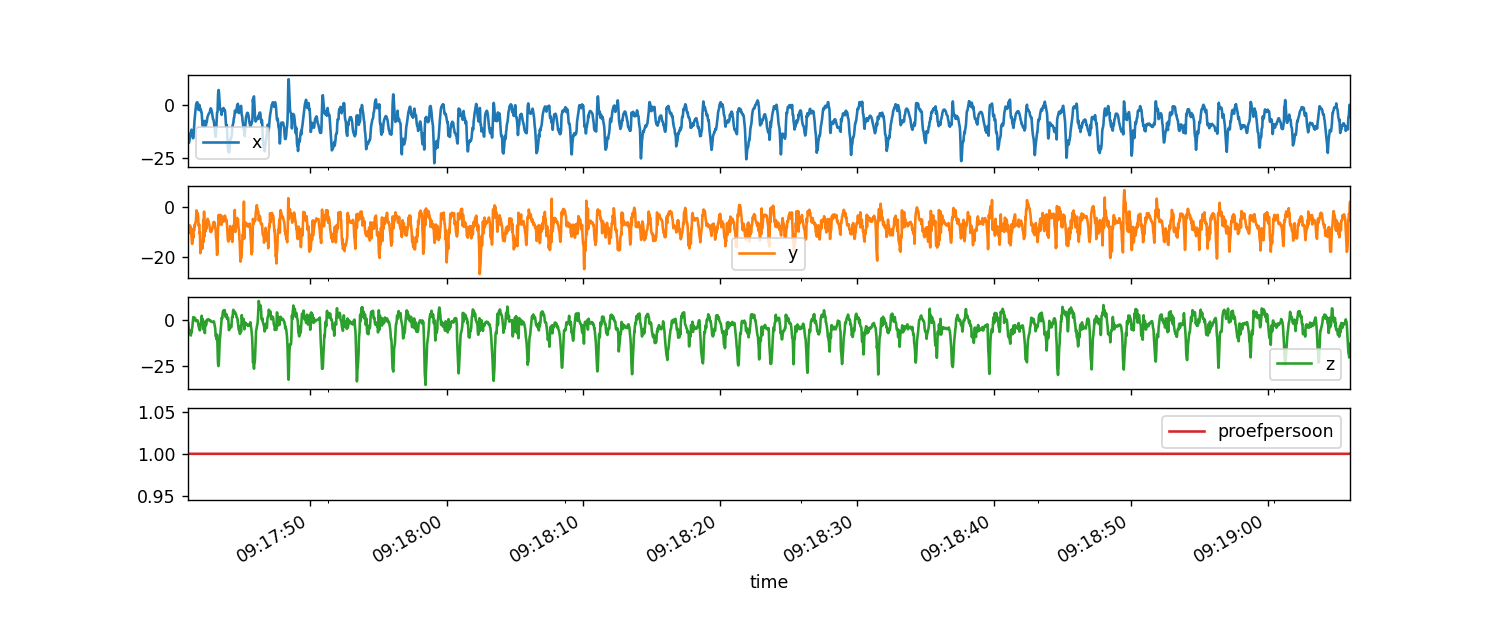

array([<matplotlib.axes._subplots.AxesSubplot object at 0x00000271A556E308>,
      dtype=object)

In [65]:
forward_180_left_right_nospringa.plot(x='time', subplots=True)

In [66]:
forward_180_left_right_1 = [forward_180_left_right_nospringa]

In [67]:
for df in forward_180_left_right_1:
    f = sampling_freq(df)
    freq += f

#### forward_180_right_right

#### tussenpauzes

In [4]:
forward_180_right_forward1 = pd.read_csv(r"C:\Users\Elise\Documents\unif\master\semester2\masterproef\gitProject\thesis\data\forward_180\proefpersoon1\forward_180_right_forward_tim.csv", sep=';', header=0, skipinitialspace=True)

FileNotFoundError: [Errno 2] File b'C:\\Users\\Elise\\Documents\\unif\\master\\semester2\\masterproef\\gitProject\\thesis\\data\\forward_180\\proefpersoon1\\forward_180_right_forward_tim.csv' does not exist: b'C:\\Users\\Elise\\Documents\\unif\\master\\semester2\\masterproef\\gitProject\\thesis\\data\\forward_180\\proefpersoon1\\forward_180_right_forward_tim.csv'

In [5]:
forward_180_right_forward1.plot(x='time', subplots=True)

NameError: name 'forward_180_right_forward1' is not defined

In [276]:
f1 = forward_180_right_forward1[forward_180_right_forward1["time"] <= 25443100000000]
f2 =  forward_180_right_forward1[(forward_180_right_forward1["time"] >= 25443100000000) & (forward_180_right_forward1["time"] <= 25447700000000)]
f3 =  forward_180_right_forward1[(forward_180_right_forward1["time"] >= 25447700000000) & (forward_180_right_forward1["time"] <= 25452500000000)]
f4 =  forward_180_right_forward1[(forward_180_right_forward1["time"] >= 25452500000000) & (forward_180_right_forward1["time"] <= 25457600000000)]
f5 =  forward_180_right_forward1[(forward_180_right_forward1["time"] >= 25457600000000) & (forward_180_right_forward1["time"] <= 25462400000000)]
f6 =  forward_180_right_forward1[(forward_180_right_forward1["time"] >= 25462400000000) & (forward_180_right_forward1["time"] <= 25467200000000)]
f7 =  forward_180_right_forward1[(forward_180_right_forward1["time"] >= 25467200000000) & (forward_180_right_forward1["time"] <= 25471900000000)]
f8 =  forward_180_right_forward1[(forward_180_right_forward1["time"] >= 25471900000000) & (forward_180_right_forward1["time"] <= 25477000000000)]

In [277]:
f1 = preprocess(f1, "forward_180", 1.2, 0.3)
f2 = preprocess(f2, "forward_180", 0.3, 0.3)
f3 = preprocess(f3, "forward_180", 0.4, 0.3)
f4 = preprocess(f4, "forward_180", 0.5, 0.5)
f5 = preprocess(f5, "forward_180", 0.5, 0.3)
f6 = preprocess(f6, "forward_180", 0.5, 0.4)
f7 = preprocess(f7, "forward_180", 0.5, 0.3)
f8 = preprocess(f8, "forward_180", 0.5, 0.4)

In [278]:
forward_180_right_forward_1 = [f1, f2, f3, f4, f5, f6, f7, f8]

#### zonder tussenpauzes

In [6]:
forward_180_right_right_1a = pd.read_csv(
    r"C:\Users\Elise\Documents\unif\master\semester2\masterproef\gitProject\thesis\data\forward_180\proefpersoon1\forward_180_right_right_tim.csv", 
    sep=';', header=0, skipinitialspace=True)

<IPython.core.display.Javascript object>


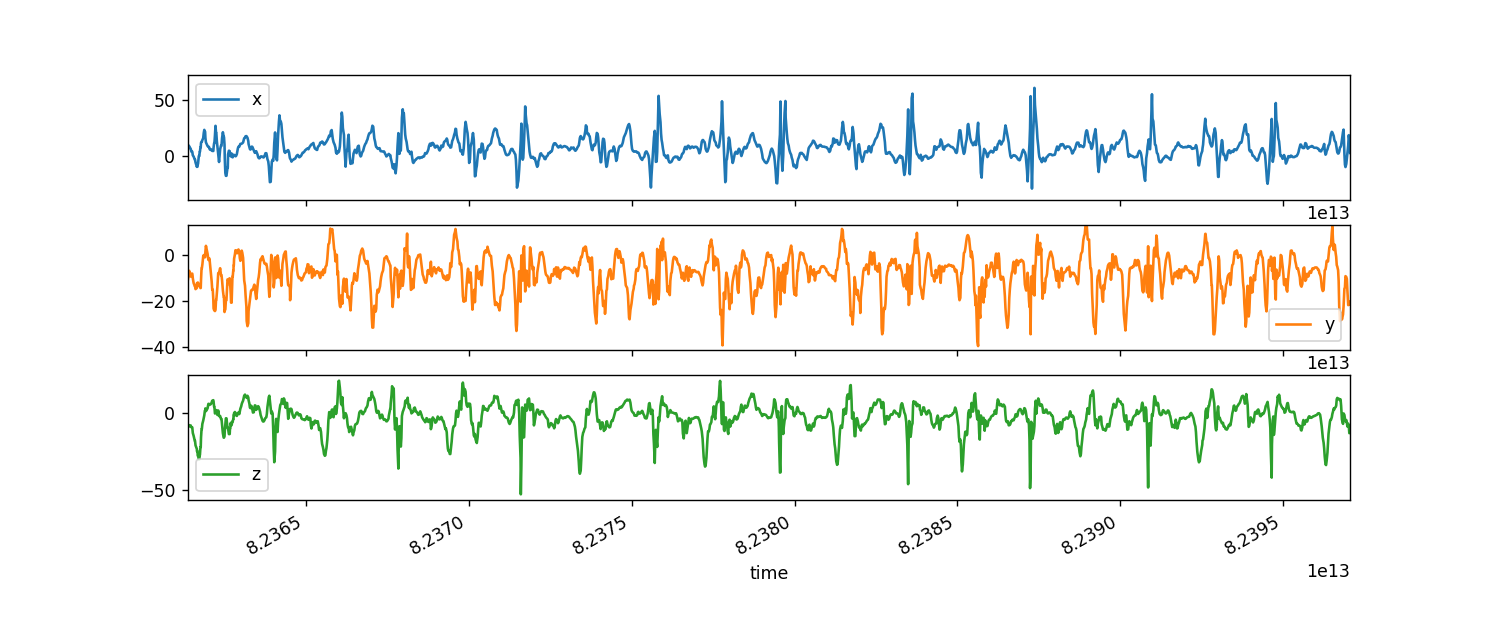

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000022C8157DF48>,
      dtype=object)

In [7]:
forward_180_right_right_1a.plot(x='time', subplots=True)

In [10]:
forward_180_right_right_1a = preprocess(forward_180_right_right_1a, "forward_180", "right_right", 1)

In [11]:
forward_180_right_right_1 = [forward_180_right_right_1a]

In [12]:
for df in forward_180_right_right_1:
    f = sampling_freq(df)
    freq += f

#### zonder tussenpauzes, zonder springen

In [68]:
forward_180_right_right_nospringa = pd.read_csv(
    r"C:\Users\Elise\Documents\unif\master\semester2\masterproef\gitProject\thesis\data\forward_180\proefpersoon1\forward_180_right_right_nospring_tim.csv", 
    sep=';', header=0, skipinitialspace=True)

In [69]:
forward_180_right_right_nospringa = preprocess(forward_180_right_right_nospringa, "forward_180", "right_right",1, 0.7, 4)

<IPython.core.display.Javascript object>


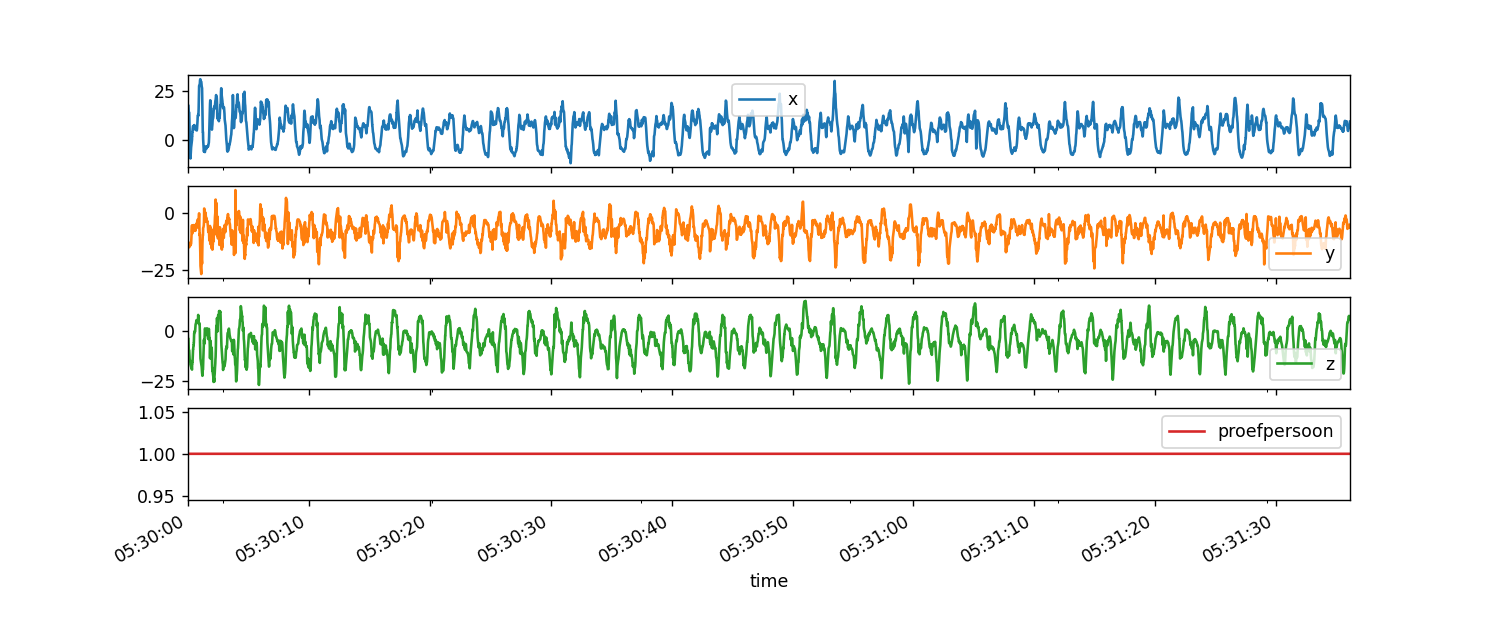

array([<matplotlib.axes._subplots.AxesSubplot object at 0x00000271A6E5AC08>,
      dtype=object)

In [70]:
forward_180_right_right_nospringa.plot(x='time', subplots=True)

In [71]:
forward_180_right_right_1 = [forward_180_right_right_nospringa]

In [72]:
for df in forward_180_right_right_1:
    f = sampling_freq(df)
    freq += f

#### forward_180_left_left

#### tussenpauze

In [280]:
#8 SEGMENTEN
forward_180_left_other_side1 = pd.read_csv(r"C:\Users\Elise\Documents\unif\master\semester2\masterproef\gitProject\thesis\data\forward_180\proefpersoon1\forward_180_left_forward_tim_other1.csv", sep=';', header=0, skipinitialspace=True)


In [282]:
f1 =  forward_180_left_other_side1[(forward_180_left_other_side1["time"] <= 32298600000000)]
f2 =  forward_180_left_other_side1[(forward_180_left_other_side1["time"] >= 32298600000000) & (forward_180_left_other_side1["time"] <= 32302600000000)]
f3 =  forward_180_left_other_side1[(forward_180_left_other_side1["time"] >= 32302600000000) & (forward_180_left_other_side1["time"] <= 32306700000000)]
f4 =  forward_180_left_other_side1[(forward_180_left_other_side1["time"] >= 32306700000000) & (forward_180_left_other_side1["time"] <= 32310800000000)]
f5 =  forward_180_left_other_side1[(forward_180_left_other_side1["time"] >= 32310800000000) & (forward_180_left_other_side1["time"] <= 32314900000000)]
f6 =  forward_180_left_other_side1[(forward_180_left_other_side1["time"] >= 32314900000000) & (forward_180_left_other_side1["time"] <= 32319000000000)]
f7 =  forward_180_left_other_side1[(forward_180_left_other_side1["time"] >= 32319000000000) & (forward_180_left_other_side1["time"] <= 32323200000000)]
f8 =  forward_180_left_other_side1[(forward_180_left_other_side1["time"] >= 32323200000000) & (forward_180_left_other_side1["time"] <= 32327700000000)]

In [283]:
f1 = preprocess(f1, "forward_180", 1.4, 0.7)
f2 = preprocess(f2, "forward_180", 0.4, 1.1)
f3 = preprocess(f3, "forward_180", 0.4, 1.2)
f4 = preprocess(f4, "forward_180", 0.6, 0.9)
f5 = preprocess(f5, "forward_180", 0.5, 1)
f6 = preprocess(f6, "forward_180", 0.5, 1.1)
f7 = preprocess(f7, "forward_180", 0.5, 1.1)
f8 = preprocess(f8, "forward_180", 0.5, 1.1)

In [285]:
forward_180_left_other_side_1 = [f1, f2, f3, f4, f5, f6, f7, f8]

#### zonder tussenpauzes

In [13]:
forward_180_left_left_1a = pd.read_csv(
    r"C:\Users\Elise\Documents\unif\master\semester2\masterproef\gitProject\thesis\data\forward_180\proefpersoon1\forward_180_left_left_tim1.csv", 
    sep=';', header=0, skipinitialspace=True)

In [14]:
forward_180_left_left_1a = preprocess(forward_180_left_left_1a, "forward_180", "left_left", 1)

In [15]:
forward_180_left_left_1 = [forward_180_left_left_1a]

In [16]:
for df in forward_180_left_left_1:
    f = sampling_freq(df)
    freq += f

#### zonder tussenpauzes, zonder springen

In [73]:
forward_180_left_left_nospringa = pd.read_csv(
    r"C:\Users\Elise\Documents\unif\master\semester2\masterproef\gitProject\thesis\data\forward_180\proefpersoon1\forward_180_left_left_tim_nospring1.csv", 
    sep=';', header=0, skipinitialspace=True)

forward_180_left_left_nospringb = pd.read_csv(
    r"C:\Users\Elise\Documents\unif\master\semester2\masterproef\gitProject\thesis\data\forward_180\proefpersoon1\forward_180_left_left_tim_nospring2.csv", 
    sep=';', header=0, skipinitialspace=True)

In [74]:
forward_180_left_left_nospringa = preprocess(forward_180_left_left_nospringa, "forward_180", "left_left",1, 2, 3)

forward_180_left_left_nospringb = preprocess(forward_180_left_left_nospringb, "forward_180", "left_left",1, 2, 2.5)

<IPython.core.display.Javascript object>


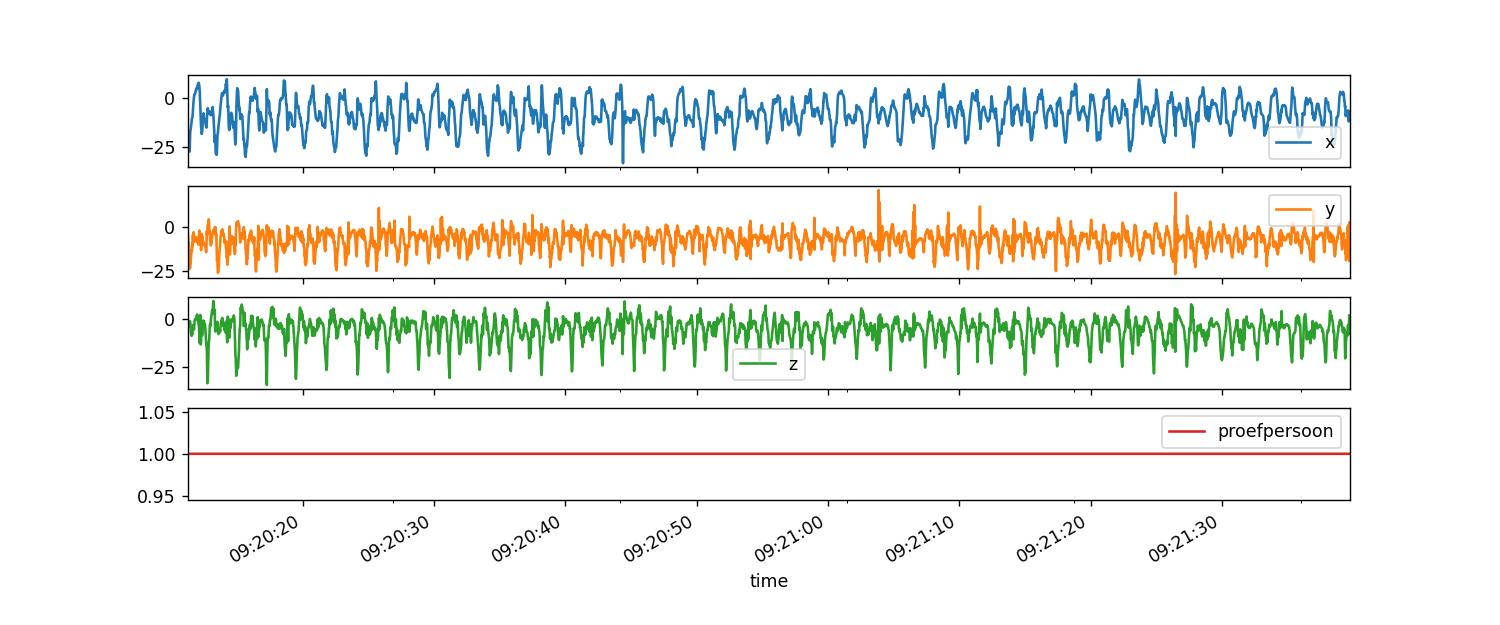

array([<matplotlib.axes._subplots.AxesSubplot object at 0x00000271A77B5D88>,
      dtype=object)

In [75]:
forward_180_left_left_nospringb.plot(x='time', subplots=True)

In [76]:
forward_180_left_left_1 = [forward_180_left_left_nospringa, forward_180_left_left_nospringb]

In [77]:
for df in forward_180_left_left_1:
    f = sampling_freq(df)
    freq += f

#### forward_180_right_left

#### tussenpauze

In [287]:
#5 SEGMENTEN
forward_180_right_other_side1 = pd.read_csv(r"C:\Users\Elise\Documents\unif\master\semester2\masterproef\gitProject\thesis\data\forward_180\proefpersoon1\forward_180_right_forward_other_side_tim1.csv", sep=';', header=0, skipinitialspace=True)
#3 SEGMENTEN
forward_180_right_other_side2 = pd.read_csv(r"C:\Users\Elise\Documents\unif\master\semester2\masterproef\gitProject\thesis\data\forward_180\proefpersoon1\forward_180_right_forward_other_side_tim2.csv", sep=';', header=0, skipinitialspace=True)


In [289]:
f1 =  forward_180_right_other_side1[(forward_180_right_other_side1["time"] <= 31692200000000)]
f2 =  forward_180_right_other_side1[(forward_180_right_other_side1["time"] >= 31692200000000) & (forward_180_right_other_side1["time"] <= 31696700000000)]
f3 =  forward_180_right_other_side1[(forward_180_right_other_side1["time"] >= 31696700000000) & (forward_180_right_other_side1["time"] <= 31701600000000)]
f4 =  forward_180_right_other_side1[(forward_180_right_other_side1["time"] >= 31701600000000) & (forward_180_right_other_side1["time"] <= 31706200000000)]
f5 =  forward_180_right_other_side1[forward_180_right_other_side1["time"] >= 31706200000000]

f6 =  forward_180_right_other_side2[(forward_180_right_other_side2["time"] <= 31728600000000)]
f7 =  forward_180_right_other_side2[(forward_180_right_other_side2["time"] >= 31728600000000) & (forward_180_right_other_side2["time"] <= 31733400000000)]
f8 =  forward_180_right_other_side2[(forward_180_right_other_side2["time"] >= 31733400000000) & (forward_180_right_other_side2["time"] <= 31738000000000)]

In [290]:
f1 = preprocess(f1, "forward_180", 1.3, 1.1)
f2 = preprocess(f2, "forward_180", 0.7, 1)
f3 = preprocess(f3, "forward_180", 0.7, 1.2)
f4 = preprocess(f4, "forward_180", 0.6, 1.2)
f5 = preprocess(f5, "forward_180", 0.7, 3.3) #DEZE FOUT
f6 = preprocess(f6, "forward_180", 1.4, 1.3)
f7 = preprocess(f7, "forward_180", 0.8, 1.1)
f8 = preprocess(f8, "forward_180", 0.7, 1)

In [292]:
forward_180_right_other_side_1 = [f1, f2, f3, f4, f5, f6, f7, f8]

#### zonder tussenpauzes

In [17]:
forward_180_right_left_1a = pd.read_csv(
    r"C:\Users\Elise\Documents\unif\master\semester2\masterproef\gitProject\thesis\data\forward_180\proefpersoon1\forward_180_right_left_tim.csv", 
    sep=';', header=0, skipinitialspace=True)

In [18]:
forward_180_right_left_1a = preprocess(forward_180_right_left_1a, "forward_180", "right_left", 1)

In [19]:
forward_180_right_left_1 = [forward_180_right_left_1a]

In [20]:
for df in forward_180_right_left_1:
    f = sampling_freq(df)
    freq += f

#### zonder tussenpauzes, zonder springen

In [78]:
forward_180_right_left_nospringa = pd.read_csv(
    r"C:\Users\Elise\Documents\unif\master\semester2\masterproef\gitProject\thesis\data\forward_180\proefpersoon1\forward_180_right_left_nospring_tim1.csv", 
    sep=';', header=0, skipinitialspace=True)

forward_180_right_left_nospringb = pd.read_csv(
    r"C:\Users\Elise\Documents\unif\master\semester2\masterproef\gitProject\thesis\data\forward_180\proefpersoon1\forward_180_right_left_nospring_tim2.csv", 
    sep=';', header=0, skipinitialspace=True)

In [79]:
forward_180_right_left_nospringa = preprocess(forward_180_right_left_nospringa, "forward_180", "right_left",1, 2, 4)

forward_180_right_left_nospringb = preprocess(forward_180_right_left_nospringb, "forward_180", "right_left",1, 2.5, 2.5)

<IPython.core.display.Javascript object>


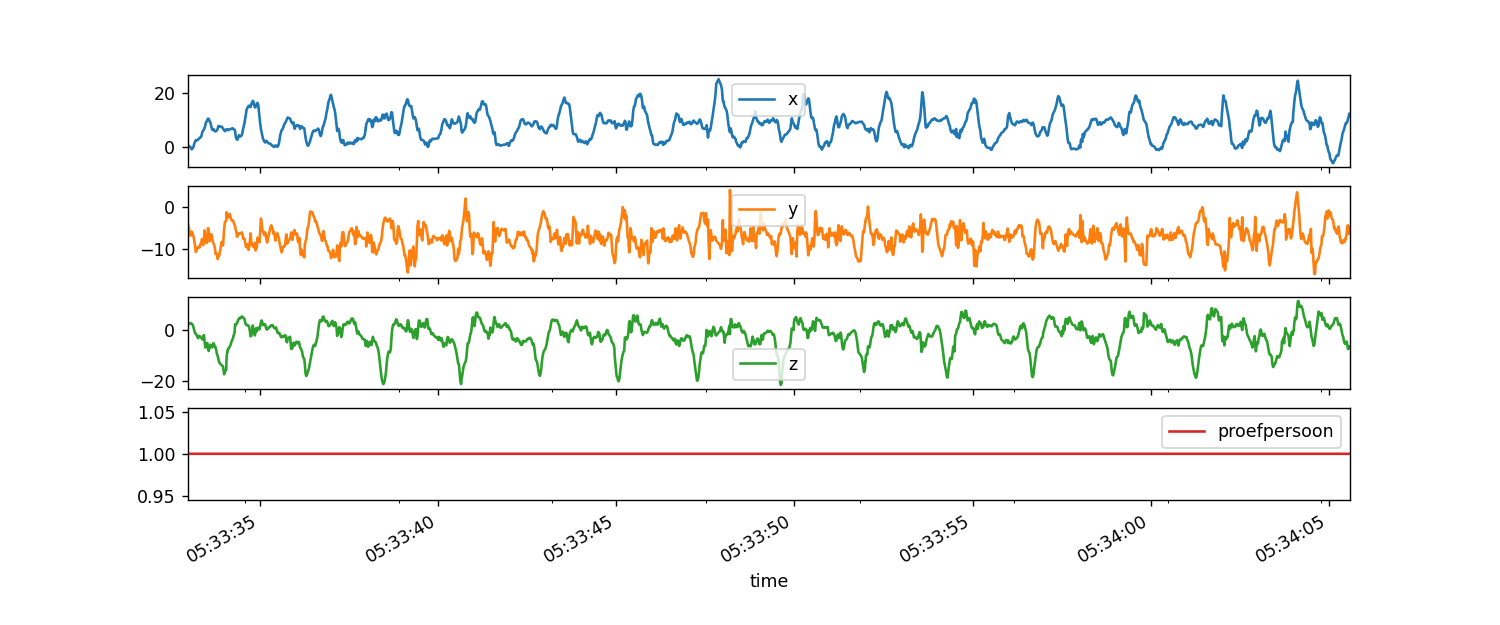

array([<matplotlib.axes._subplots.AxesSubplot object at 0x00000271A810CD48>,
      dtype=object)

In [80]:
forward_180_right_left_nospringb.plot(x='time', subplots=True)

In [81]:
forward_180_right_left_1 = [forward_180_right_left_nospringa, forward_180_right_left_nospringb]

In [82]:
for df in forward_180_right_left_1:
    f = sampling_freq(df)
    freq += f

### SEGMENTATION

In [83]:
if(not raw):
    #segmentation + feature extraction
    for i in range(0, len(forward_180_left_right_1)):
        forward_180_left_right_1[i] =  feature_extraction_segmentation(forward_180_left_right_1[i],1, True)

    for i in range(0, len(forward_180_right_right_1)):
        forward_180_right_right_1[i] =  feature_extraction_segmentation(forward_180_right_right_1[i],1, True)
    
    for i in range(0, len(forward_180_left_left_1)):
        forward_180_left_left_1[i] =  feature_extraction_segmentation(forward_180_left_left_1[i],1, True)

    for i in range(0, len(forward_180_right_left_1)):
        forward_180_right_left_1[i] =  feature_extraction_segmentation(forward_180_right_left_1[i],1, True)

In [84]:
forward_180_left_right_1 = pd.concat(forward_180_left_right_1, ignore_index=True)
forward_180_left_right_1.shape

(4392, 7)

In [85]:
forward_180_right_right_1 = pd.concat(forward_180_right_right_1, ignore_index=True)
forward_180_right_right_1.shape

(5020, 7)

In [86]:
forward_180_left_left_1 = pd.concat(forward_180_left_left_1, ignore_index=True)
forward_180_left_left_1.shape

(5105, 7)

In [87]:
forward_180_right_left_1 = pd.concat(forward_180_right_left_1, ignore_index=True)
forward_180_right_left_1.shape

(5264, 7)

### SHUFFLE - BALANCING

In [88]:
shape = np.min([
    forward_180_left_right_1.shape[0], 
    forward_180_right_right_1.shape[0], 
    forward_180_left_left_1.shape[0], 
    forward_180_right_left_1.shape[0]])

#### shuffle

In [53]:
forward_180_left_right_1 = shuffle(forward_180_left_right_1).head(shape).copy()
forward_180_right_right_1 = shuffle(forward_180_right_right_1).head(shape).copy()
forward_180_left_left_1 = shuffle(forward_180_left_left_1).head(shape).copy()
forward_180_right_left_1 = shuffle(forward_180_right_left_1).head(shape).copy()

#### no shuffle

In [89]:
forward_180_left_right_1 = forward_180_left_right_1.head(shape).copy()
forward_180_right_right_1 = forward_180_right_right_1.head(shape).copy()
forward_180_left_left_1 = forward_180_left_left_1.head(shape).copy()
forward_180_right_left_1 = forward_180_right_left_1.head(shape).copy()

In [90]:
forward_180_1 = pd.concat([forward_180_left_right_1, forward_180_right_right_1, forward_180_left_left_1, forward_180_right_left_1])

# <font color='green' >PROEFPERSOON 2

## forward 180

OPM: window data van 2 verschillende forward 180s => niet realistisch

In [91]:
forward_180_left_right_2 = []
forward_180_right_right_2 = []
forward_180_left_left_2 = []
forward_180_right_left_2  = []

#### forward_180_left_right

#### tussenpauze

<font color='red'>TODO</font>: in preprocessing uitknippen!!!!!!!! (forward_180_2)

In [303]:
#8 SEGMENTEN, niet volledig
forward_180 = pd.read_csv(r"C:\Users\Elise\Documents\unif\master\semester2\masterproef\gitProject\thesis\data\forward_180\proefpersoon2\forward_180_left_forward1.csv", sep=';', header=0, skipinitialspace=True)

In [304]:
f1 =  forward_180[(forward_180["time"] <= 20518400000000)]
f2 =  forward_180[(forward_180["time"] >= 20518400000000) & (forward_180["time"] <= 20523600000000)]
f3 =  forward_180[(forward_180["time"] >= 20523600000000) & (forward_180["time"] <= 20528600000000)]
f4 =  forward_180[(forward_180["time"] >= 20528600000000) & (forward_180["time"] <= 20533700000000)]
f5 =  forward_180[(forward_180["time"] >= 20533700000000) & (forward_180["time"] <= 20539000000000)]
f6 =  forward_180[(forward_180["time"] >= 20539000000000) & (forward_180["time"] <= 20544100000000)]
f7 =  forward_180[(forward_180["time"] >= 20544100000000) & (forward_180["time"] <= 20549400000000)]
f8 =  forward_180[(forward_180["time"] >= 20549400000000) & (forward_180["time"] <= 20554500000000)]

In [305]:
f1 = preprocess(f1, "forward_180", 1.5, 1.5)
f2 = preprocess(f2, "forward_180", 1.3, 0.7)
f3 = preprocess(f3, "forward_180", 1, 1)
f4 = preprocess(f4, "forward_180", 1, 1)
f5 = preprocess(f5, "forward_180", 1, 1)
f6 = preprocess(f6, "forward_180", 1, 1)
f7 = preprocess(f7, "forward_180", 1, 1.2)
f8 = preprocess(f8, "forward_180", 1, 1)

In [306]:
forward_180_left_forward_2 = [f1, f2, f3, f4, f5, f6, f7, f8]

#### zonder tussenpauzes

In [30]:
forward_180_left_right_2a = pd.read_csv(
    r"C:\Users\Elise\Documents\unif\master\semester2\masterproef\gitProject\thesis\data\forward_180\proefpersoon2\forward_180_left_right.csv", 
    sep=';', header=0, skipinitialspace=True)

In [31]:
forward_180_left_right_2a = preprocess(forward_180_left_right_2a, "forward_180", "left_right", 2)

In [32]:
forward_180_left_right_2 = [forward_180_left_right_2a]

In [33]:
for df in forward_180_left_right_2:
    f = sampling_freq(df)
    freq += f

#### zonder tussenpauzes, zonder springen

In [92]:
forward_180_nospringa = pd.read_csv(
    r"C:\Users\Elise\Documents\unif\master\semester2\masterproef\gitProject\thesis\data\forward_180\proefpersoon2\forward_180_left_right_nospring.csv", 
    sep=';', header=0, skipinitialspace=True)

In [93]:
forward_180_nospringa = preprocess(forward_180_nospringa, "forward_180", "left_right",2, 0.7, 4.4)

<IPython.core.display.Javascript object>


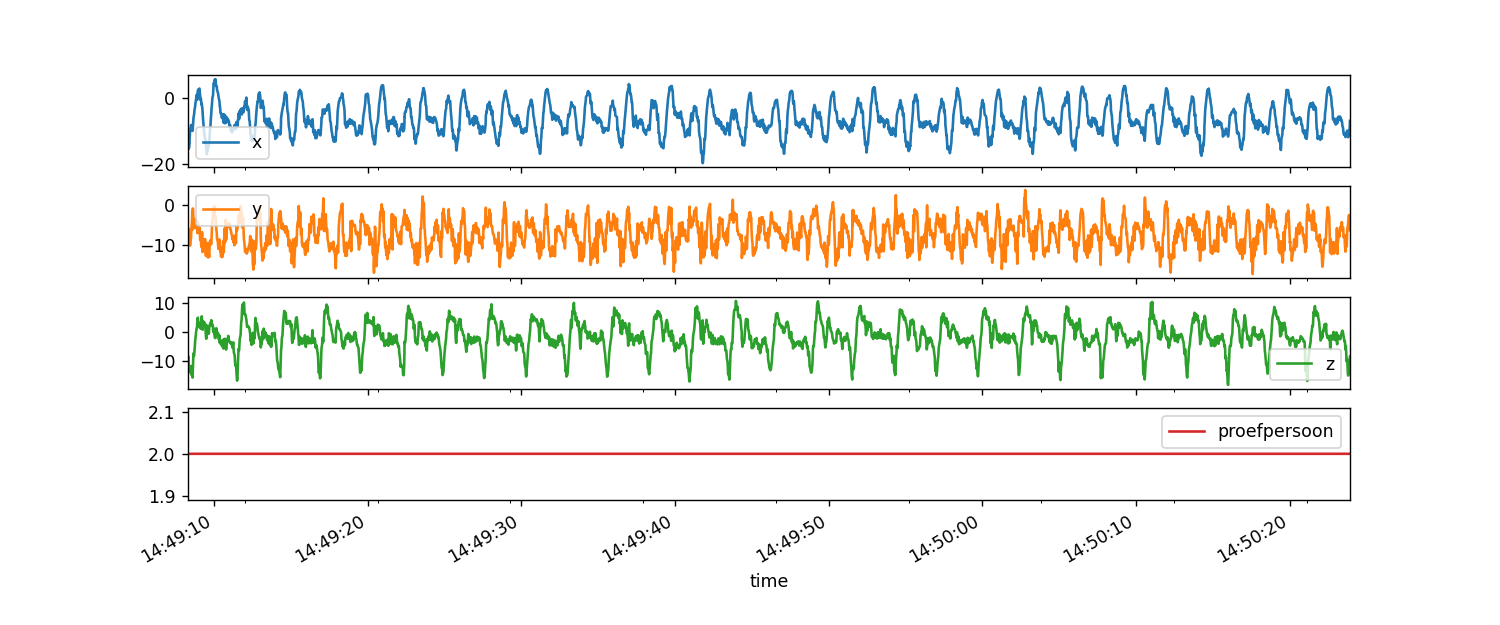

array([<matplotlib.axes._subplots.AxesSubplot object at 0x00000271A8A5F588>,
      dtype=object)

In [94]:
forward_180_nospringa.plot(x='time', subplots=True)

In [95]:
forward_180_left_right_2 = [forward_180_nospringa]

In [96]:
for df in forward_180_left_right_2:
    f = sampling_freq(df)
    freq += f

#### forward_180_right_right

#### tussenpauze

In [308]:
#7 SEGMENTEN
forward_180_right_forward3 = pd.read_csv(r"C:\Users\Elise\Documents\unif\master\semester2\masterproef\gitProject\thesis\data\forward_180\proefpersoon2\forward_180_right_forward3.csv", sep=';', header=0, skipinitialspace=True)

#1 SEGMENT, eerste stuk niet
forward_180_right_forward4 = pd.read_csv(r"C:\Users\Elise\Documents\unif\master\semester2\masterproef\gitProject\thesis\data\forward_180\proefpersoon2\forward_180_right_forward4.csv", sep=';', header=0, skipinitialspace=True)
forward_180_right_forward5 = pd.read_csv(r"C:\Users\Elise\Documents\unif\master\semester2\masterproef\gitProject\thesis\data\forward_180\proefpersoon2\forward_180_right_forward5.csv", sep=';', header=0, skipinitialspace=True)
forward_180_right_forward6 = pd.read_csv(r"C:\Users\Elise\Documents\unif\master\semester2\masterproef\gitProject\thesis\data\forward_180\proefpersoon2\forward_180_right_forward6.csv", sep=';', header=0, skipinitialspace=True)

In [309]:
f1 =  forward_180_right_forward3[(forward_180_right_forward3["time"] <= 11500400000000)]
f2 =  forward_180_right_forward3[(forward_180_right_forward3["time"] >= 11500400000000) & (forward_180_right_forward3["time"] <= 11504900000000)]
f3 =  forward_180_right_forward3[(forward_180_right_forward3["time"] >= 11504900000000) & (forward_180_right_forward3["time"] <= 11509600000000)]
f4 =  forward_180_right_forward3[(forward_180_right_forward3["time"] >= 11509600000000) & (forward_180_right_forward3["time"] <= 11514100000000)]
f5 =  forward_180_right_forward3[(forward_180_right_forward3["time"] >= 11514100000000) & (forward_180_right_forward3["time"] <= 11518500000000)]
f6 =  forward_180_right_forward3[(forward_180_right_forward3["time"] >= 11518500000000) & (forward_180_right_forward3["time"] <= 11523200000000)]
f7 =  forward_180_right_forward3[(forward_180_right_forward3["time"] >= 11523200000000)]

f8 =  forward_180_right_forward4[(forward_180_right_forward4["time"] >= 11533300000000) & (forward_180_right_forward4["time"] <= 11537900000000)]

In [310]:
f1 = preprocess(f1, "forward_180", 1.2, 1)
f2 = preprocess(f2, "forward_180", 0.8, 1)
f3 = preprocess(f3, "forward_180", 0.7, 0.8)
f4 = preprocess(f4, "forward_180", 0.9, 0.6)
f5 = preprocess(f5, "forward_180", 0.7, 0.5)
f6 = preprocess(f6, "forward_180", 0.7, 0.7)
f7 = preprocess(f7, "forward_180", 0.9, 1.25)
f8 = preprocess(f8, "forward_180", 0.8, 0.7)

In [311]:
forward_180_right_forward_2 = [f1, f2, f3, f4, f5, f6, f7, f8]

#### zonder tussenpauzes

In [34]:
forward_180_right_right_2a = pd.read_csv(
    r"C:\Users\Elise\Documents\unif\master\semester2\masterproef\gitProject\thesis\data\forward_180\proefpersoon2\forward_180_right_right1.csv", 
    sep=';', header=0, skipinitialspace=True)

forward_180_right_right_2b = pd.read_csv(
    r"C:\Users\Elise\Documents\unif\master\semester2\masterproef\gitProject\thesis\data\forward_180\proefpersoon2\forward_180_right_right2.csv", 
    sep=';', header=0, skipinitialspace=True)

In [35]:
forward_180_right_right_2a = preprocess(forward_180_right_right_2a, "forward_180", "right_right", 2)
forward_180_right_right_2b = preprocess(forward_180_right_right_2b, "forward_180", "right_right", 2)

In [36]:
forward_180_right_right_2 = [forward_180_right_right_2a, forward_180_right_right_2b]

In [37]:
for df in forward_180_right_right_2:
    f = sampling_freq(df)
    freq += f

#### zonder tussenpauzes, zonder springen

In [97]:
forward_180_right_right_nospringa = pd.read_csv(
    r"C:\Users\Elise\Documents\unif\master\semester2\masterproef\gitProject\thesis\data\forward_180\proefpersoon2\forward_180_right_right_nospring1.csv", 
    sep=';', header=0, skipinitialspace=True)

In [98]:
forward_180_right_right_nospringa = preprocess(forward_180_right_right_nospringa, "forward_180", "right_right",2, 1, 4)

<IPython.core.display.Javascript object>


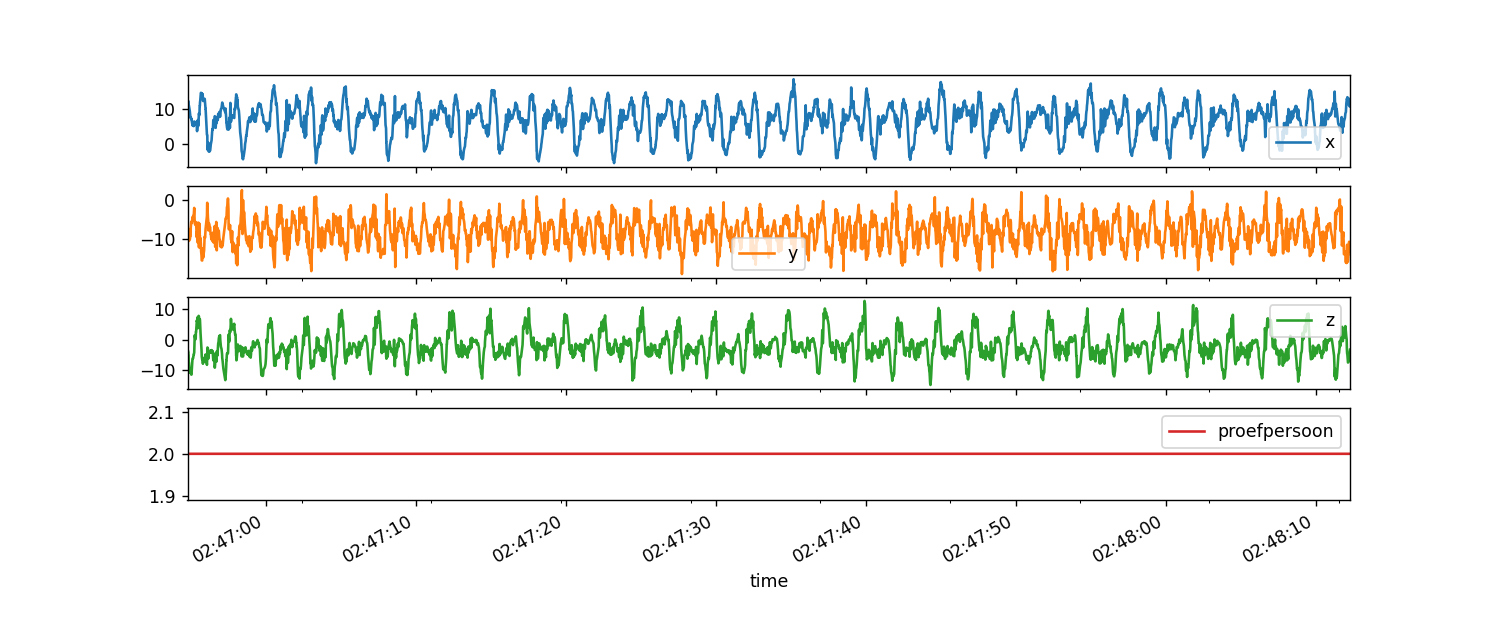

array([<matplotlib.axes._subplots.AxesSubplot object at 0x00000271A93A2108>,
      dtype=object)

In [99]:
forward_180_right_right_nospringa.plot(x='time', subplots=True)

In [100]:
forward_180_right_right_2 = [forward_180_right_right_nospringa]

In [101]:
for df in forward_180_right_right_2:
    f = sampling_freq(df)
    freq += f

#### forward_180_left_left

#### tussenpauze

In [313]:

forward_180_left_other1 = pd.read_csv(r"C:\Users\Elise\Documents\unif\master\semester2\masterproef\gitProject\thesis\data\forward_180\proefpersoon2\forward_180_left_back_otherside1.csv", sep=';', header=0, skipinitialspace=True)

In [314]:
f1 =  forward_180_left_other1[(forward_180_left_other1["time"] <= 20761200000000)]
f2 =  forward_180_left_other1[(forward_180_left_other1["time"] >= 20761200000000) & (forward_180_left_other1["time"] <= 20766600000000)]
f3 =  forward_180_left_other1[(forward_180_left_other1["time"] >= 20766600000000) & (forward_180_left_other1["time"] <= 20772000000000)]
f4 =  forward_180_left_other1[(forward_180_left_other1["time"] >= 20772000000000) & (forward_180_left_other1["time"] <= 20777400000000)]
f5 =  forward_180_left_other1[(forward_180_left_other1["time"] >= 20777400000000) & (forward_180_left_other1["time"] <= 20782800000000)]
f6 =  forward_180_left_other1[(forward_180_left_other1["time"] >= 20782800000000) & (forward_180_left_other1["time"] <= 20787700000000)]
f7 =  forward_180_left_other1[(forward_180_left_other1["time"] >= 20787700000000) & (forward_180_left_other1["time"] <= 20793000000000)]
f8 =  forward_180_left_other1[(forward_180_left_other1["time"] >= 20793000000000) & (forward_180_left_other1["time"] <= 20798900000000)]

In [315]:
f1 = preprocess(f1, "forward_180", 1.7, 1)
f2 = preprocess(f2, "forward_180", 1.5, 1)
f3 = preprocess(f3, "forward_180", 1.5, 0.8)
f4 = preprocess(f4, "forward_180", 1.7, 0.8)
f5 = preprocess(f5, "forward_180", 1.6, 1)
f6 = preprocess(f6, "forward_180", 1.1, 0.9)
f7 = preprocess(f7, "forward_180", 1.3, 1)
f8 = preprocess(f8, "forward_180", 1.7, 1.2)

In [316]:
forward_180_left_other_side_2 = [f1, f2, f3, f4, f5, f6, f7, f8]

#### zonder tussenpauzes

In [38]:
forward_180_left_left_2a = pd.read_csv(
    r"C:\Users\Elise\Documents\unif\master\semester2\masterproef\gitProject\thesis\data\forward_180\proefpersoon2\forward_180_left_left.csv", 
    sep=';', header=0, skipinitialspace=True)

In [39]:
forward_180_left_left_2a = preprocess(forward_180_left_left_2a, "forward_180", "left_left", 2)

In [40]:
forward_180_left_left_2 = [forward_180_left_left_2a]

In [41]:
for df in forward_180_left_left_2:
    f = sampling_freq(df)
    freq += f

#### zonder tussenpauzes, zonder springen

In [102]:
forward_180_left_left_nospringa = pd.read_csv(
    r"C:\Users\Elise\Documents\unif\master\semester2\masterproef\gitProject\thesis\data\forward_180\proefpersoon2\forward_180_left_left_nospring.csv", 
    sep=';', header=0, skipinitialspace=True)

In [103]:
forward_180_left_left_nospringa = preprocess(forward_180_left_left_nospringa, "forward_180", "left_left",2, 3.5, 4.8)

<IPython.core.display.Javascript object>


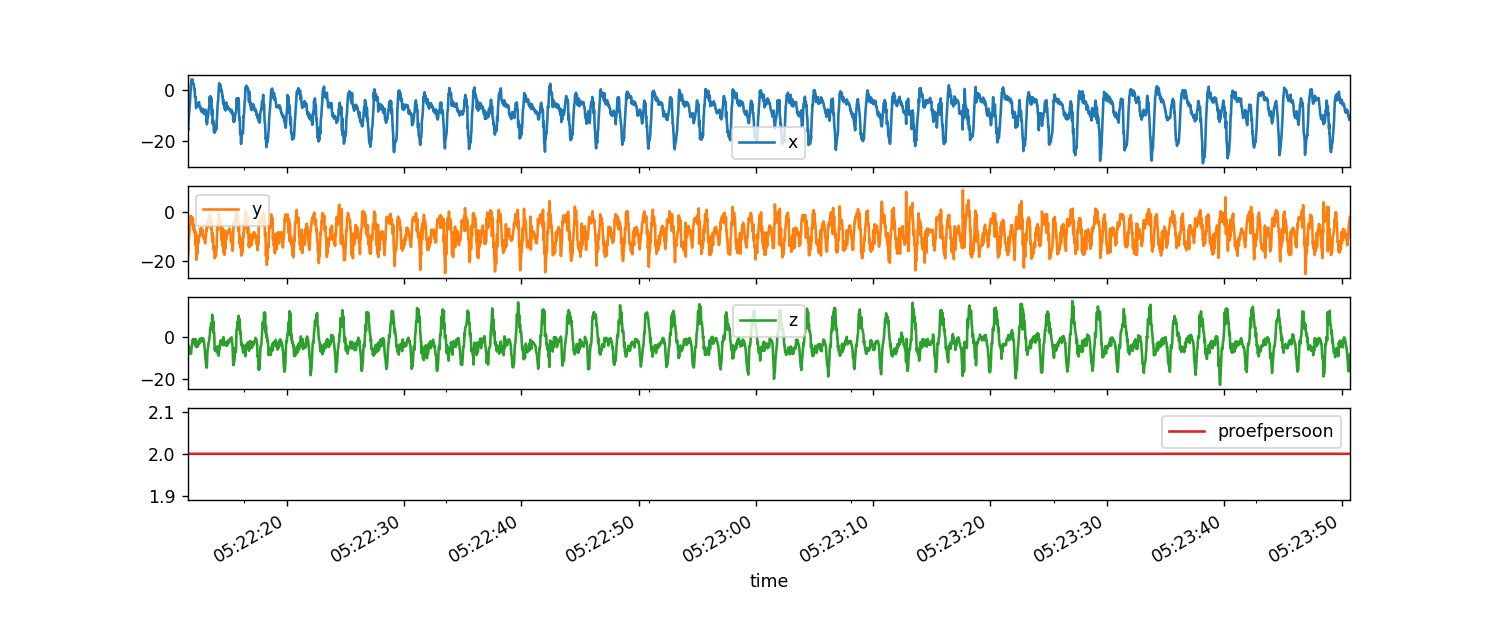

array([<matplotlib.axes._subplots.AxesSubplot object at 0x00000271A9506908>,
      dtype=object)

In [104]:
forward_180_left_left_nospringa.plot(x='time', subplots=True)

In [105]:
forward_180_left_left_2 = [forward_180_left_left_nospringa]

In [106]:
for df in forward_180_left_left_2:
    f = sampling_freq(df)
    freq += f

#### forward_180_right_left

#### tussenpauze

In [318]:
#8 SEGMENTEN
forward_180_right_other1 = pd.read_csv(r"C:\Users\Elise\Documents\unif\master\semester2\masterproef\gitProject\thesis\data\forward_180\proefpersoon2\forward_180_right_forward_otherside.csv", sep=';', header=0, skipinitialspace=True)

In [320]:
f1 =  forward_180_right_other1[(forward_180_right_other1["time"] <= 20932900000000)]
f2 =  forward_180_right_other1[(forward_180_right_other1["time"] >= 20932900000000) & (forward_180_right_other1["time"] <= 20938800000000)]
f3 =  forward_180_right_other1[(forward_180_right_other1["time"] >= 20938800000000) & (forward_180_right_other1["time"] <= 20944700000000)]
f4 =  forward_180_right_other1[(forward_180_right_other1["time"] >= 20944700000000) & (forward_180_right_other1["time"] <= 20950400000000)]
f5 =  forward_180_right_other1[(forward_180_right_other1["time"] >= 20950400000000) & (forward_180_right_other1["time"] <= 20956000000000)]
f6 =  forward_180_right_other1[(forward_180_right_other1["time"] >= 20956000000000) & (forward_180_right_other1["time"] <= 20961400000000)]
f7 =  forward_180_right_other1[(forward_180_right_other1["time"] >= 20961400000000) & (forward_180_right_other1["time"] <= 20966500000000)]
f8 =  forward_180_right_other1[(forward_180_right_other1["time"] >= 20966500000000) & (forward_180_right_other1["time"] <= 20971800000000)]

In [321]:
f1 = preprocess(f1, "forward_180", 1, 1.2)
f2 = preprocess(f2, "forward_180", 1.2, 1.2)
f3 = preprocess(f3, "forward_180", 1.3, 1.4)
f4 = preprocess(f4, "forward_180", 1.3, 1.6)
f5 = preprocess(f5, "forward_180", 1.3, 1.5)
f6 = preprocess(f6, "forward_180", 1.3, 1.1)
f7 = preprocess(f7, "forward_180", 1.05, 1.4)
f8 = preprocess(f8, "forward_180", 1.1, 1.4)

In [323]:
forward_180_right_other_side_2 = [f1, f2, f3, f4, f5, f6, f7, f8]

#### zonder tussenpauzes

In [42]:
forward_180_right_left_2a = pd.read_csv(
    r"C:\Users\Elise\Documents\unif\master\semester2\masterproef\gitProject\thesis\data\forward_180\proefpersoon2\forward_180_right_left.csv", 
    sep=';', header=0, skipinitialspace=True)

In [43]:
forward_180_right_left_2a = preprocess(forward_180_right_left_2a, "forward_180", "right_left", 2)

In [44]:
forward_180_right_left_2 = [forward_180_right_left_2a]

In [45]:
for df in forward_180_right_left_2:
    f = sampling_freq(df)
    freq += f

#### zonder tussenpauzes, zonder springen

In [107]:
forward_180_right_left_nospringa = pd.read_csv(
    r"C:\Users\Elise\Documents\unif\master\semester2\masterproef\gitProject\thesis\data\forward_180\proefpersoon2\forward_180_right_left_nospring.csv", 
    sep=';', header=0, skipinitialspace=True)

In [108]:
forward_180_right_left_nospringa = preprocess(forward_180_right_left_nospringa, "forward_180", "right_left",2, 2.5, 4)

<IPython.core.display.Javascript object>


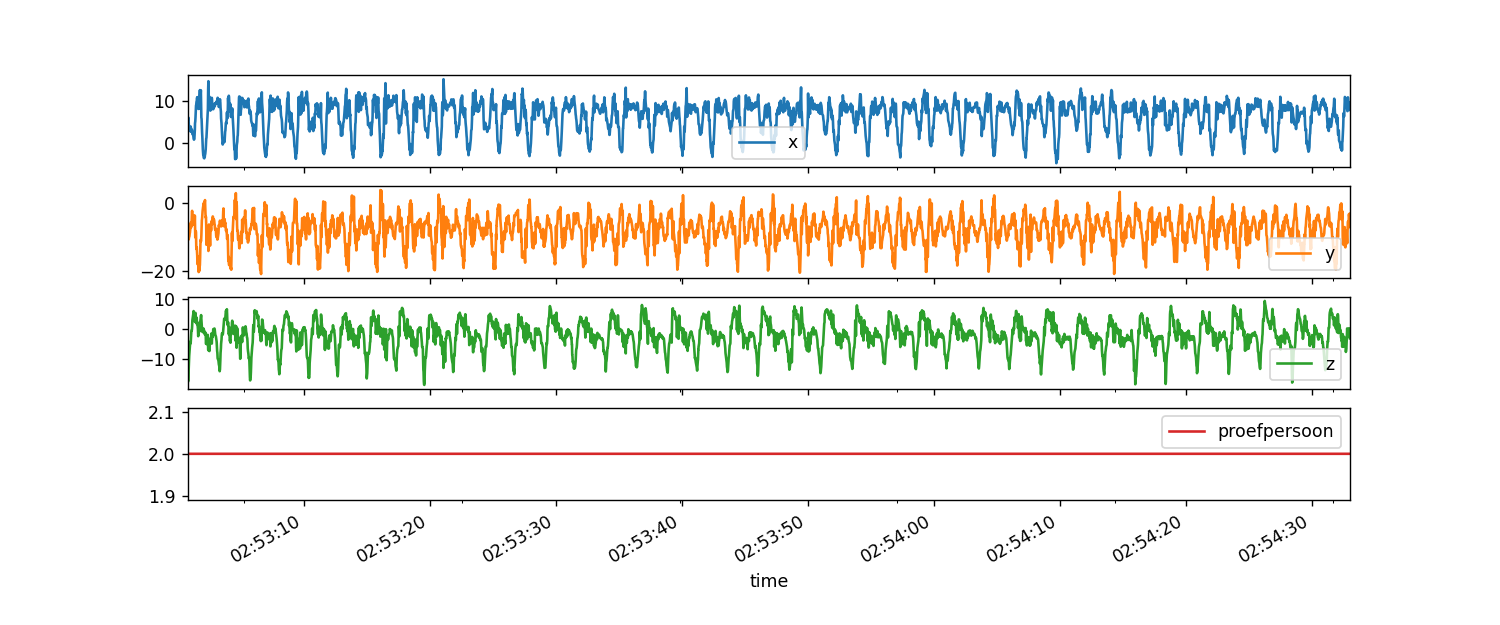

array([<matplotlib.axes._subplots.AxesSubplot object at 0x00000271AB6108C8>,
      dtype=object)

In [109]:
forward_180_right_left_nospringa.plot(x='time', subplots=True)

In [110]:
forward_180_right_left_2 = [forward_180_right_left_nospringa]

In [111]:
for df in forward_180_right_left_2:
    f = sampling_freq(df)
    freq += f

### SEGMENTATION

In [112]:
if(not raw):
    #segmentation + feature extraction
    for i in range(0, len(forward_180_left_right_2)):
        forward_180_left_right_2[i] =  feature_extraction_segmentation(forward_180_left_right_2[i],1, True)

    for i in range(0, len(forward_180_right_right_2)):
        forward_180_right_right_2[i] =  feature_extraction_segmentation(forward_180_right_right_2[i],1, True)

    for i in range(0, len(forward_180_left_left_2)):
        forward_180_left_left_2[i] =  feature_extraction_segmentation(forward_180_left_left_2[i],1, True)
    
    for i in range(0, len(forward_180_right_left_2)):
        forward_180_right_left_2[i] =  feature_extraction_segmentation(forward_180_right_left_2[i],1, True)
    

In [113]:
forward_180_left_right_2 = pd.concat(forward_180_left_right_2, ignore_index=True)
forward_180_left_right_2.shape

(3882, 7)

In [114]:
forward_180_right_right_2 = pd.concat(forward_180_right_right_2, ignore_index=True)
forward_180_right_right_2.shape

(4028, 7)

In [115]:
forward_180_left_left_2 = pd.concat(forward_180_left_left_2, ignore_index=True)
forward_180_left_left_2.shape

(5145, 7)

In [116]:
forward_180_right_left_2 = pd.concat(forward_180_right_left_2, ignore_index=True)
forward_180_right_left_2.shape

(4787, 7)

### SHUFFLE - BALANCING

In [117]:
shape = np.min([
    forward_180_left_right_2.shape[0], 
    forward_180_right_right_2.shape[0], 
    forward_180_left_left_2.shape[0], 
    forward_180_right_left_2.shape[0]])

#### shuffle

In [48]:
forward_180_left_right_2 = shuffle(forward_180_left_right_2).head(shape).copy()
forward_180_right_right_2 = shuffle(forward_180_right_right_2).head(shape).copy()
forward_180_left_left_2 = shuffle(forward_180_left_left_2).head(shape).copy()
forward_180_right_left_2 = shuffle(forward_180_right_left_2).head(shape).copy()

#### no shuffle

In [118]:
forward_180_left_right_2 = forward_180_left_right_2.head(shape).copy()
forward_180_right_right_2 = forward_180_right_right_2.head(shape).copy()
forward_180_left_left_2 = forward_180_left_left_2.head(shape).copy()
forward_180_right_left_2 = forward_180_right_left_2.head(shape).copy()

In [119]:
forward_180_2 = pd.concat([
    forward_180_left_right_2, 
    forward_180_right_right_2, 
    forward_180_left_left_2, 
    forward_180_right_left_2])

# <font color='green'> Frequency

In [54]:
#mean
freq = freq/64
freq

7.281122008987271

# <font color='green'> Merging datasets

In [120]:
shape = np.min([
    forward_180_1.shape[0],
    forward_180_2.shape[0]
])

#### shuffle

In [56]:
dataset = pd.concat([
    shuffle(forward_180_1).head(shape),
    shuffle(forward_180_2).head(shape)
])
dataset.shape

(744, 22)

#### no shuffle

In [121]:
dataset = pd.concat([
    forward_180_1.head(shape),
    forward_180_2.head(shape)
])
dataset.shape

(31056, 7)

In [122]:
dataset.to_csv("forward_180_zonder_pauze_raw.csv", sep=';')